In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Business-as-usual analysis

In [8]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from ema_workbench import load_results
from unbreakable.analysis.analyzer import *
from unbreakable.analysis.visualizer import *
sns.set_theme(style="ticks")

In [9]:
savefig = True
savetab = False

## Load results

In [10]:
# Load results
n_scenarios = 500
n_policies = 0
results = load_results(f'../experiments/scenarios={n_scenarios}, policies={n_policies}.tar.gz')

# Prepare outcomes
outcomes = prepare_outcomes(results, add_uncertainties=False, add_policies=False)

## EDA

### Single scenario, single district 

In [5]:
# Print all outcomes for a single scenario
scenario = 0
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)
numeric_columns = outcomes.columns[3:-1].tolist()
df[numeric_columns].round(2).style.format("{:,.2f}")

,random_seed,total_population,total_asset_loss,total_consumption_loss,tot_exposed_asset,median_productivity,tot_asset_surv,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,district_pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,mean_recovery_rate,n_new_poor_increase_pp
district,,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"133,600.00","8,666.91","1,282,641.50","1,098,338.74","47,442,177.05",0.63,"334,331,195.84",0.03,647.56,"1,591.22",914.27,"1,282,936.18","3,292.00",342.00,15.00,32.85,33.98,169.61,11.14,1.17,0.61,0.17
Castries,"133,600.00","70,959.09","30,985,686.74","19,708,267.65","1,587,405,663.34",0.11,"3,435,721,049.12",0.02,"3,068.68","6,213.45","2,976.86","31,062,668.40","15,948.00",505.00,0.00,34.78,34.97,642.24,10.06,1.57,0.16,0.00
Choiseul,"133,600.00","5,475.87","1,089,192.78","767,942.10","54,354,802.37",0.23,"377,890,219.98",0.02,407.98,"1,932.86",926.75,"1,111,847.84",923.00,93.00,69.00,26.55,25.43,188.23,10.48,1.42,0.17,1.26
Dennery,"133,600.00","11,590.78","2,627,956.44","1,699,934.76","125,372,604.01",2.46,"417,528,403.13",0.02,785.41,"3,383.57","1,934.66","2,667,414.34","5,216.00",388.00,0.00,23.52,24.12,216.44,6.81,1.55,2.16,0.00
Gros Islet,"133,600.00","27,467.06","11,191,757.10","9,397,907.74","532,061,766.39",0.70,"3,294,339,146.51",0.02,"1,734.44","2,841.95","1,040.60","10,932,607.53","3,245.00",66.00,0.00,15.39,15.87,541.84,17.68,1.19,0.63,0.00
Laborie,"133,600.00","6,828.32","2,084,660.70","1,304,625.87","99,235,698.32",0.12,"215,695,044.06",0.02,375.75,"5,123.26","2,964.26","2,035,118.22","1,599.00",41.00,16.00,23.26,23.19,347.21,7.26,1.60,0.18,0.23
Micoud,"133,600.00","17,435.51","4,801,731.45","3,600,042.93","231,995,156.10",0.26,"554,020,360.02",0.02,925.47,"6,056.25","2,698.00","4,766,541.74","5,433.00",222.00,116.00,38.18,37.69,389.00,10.23,1.33,0.18,0.67
Soufriere,"133,600.00","8,985.05","1,688,983.49","1,339,480.91","82,756,712.06",0.18,"535,928,432.44",0.02,455.09,"2,953.40",994.91,"1,679,254.31","2,295.00",107.00,36.00,31.47,31.59,294.33,10.71,1.26,0.23,0.40
Vieuxfort,"133,600.00","15,229.37","4,234,399.54","3,002,012.07","216,534,648.76",0.75,"1,266,550,258.12",0.02,"1,250.92","2,121.05","1,101.52","4,264,030.49","5,272.00",311.00,286.00,23.35,22.73,239.98,11.88,1.41,0.60,1.88


In [6]:
# Let's examine a single scenario in details
scenario = 0
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)

# And a single district as an example
district = 'Anse-La-Raye & Canaries'
total_population = round(df.loc[district, 'total_population'])
n_affected = round(df.loc[district, 'n_affected_people'])
print('Total population: ', total_population)
print('Number of affected people: ', n_affected)

n_poor_initial = round(df.loc[district, 'n_poor_initial'])
n_new_poor = round(df.loc[district, 'n_new_poor'])
pct_poor_initial = round(n_poor_initial / total_population * 100, 2)
pct_new_poor = round((n_new_poor + n_poor_initial) / total_population * 100, 2)
pct_poor_increase = round(n_new_poor / total_population * 100, 2)
initial_poverty_gap = round(df.loc[district, 'initial_poverty_gap'], 2)
new_poverty_gap = round(df.loc[district, 'new_poverty_gap'], 2)
print()
print('Number of poor: ', n_poor_initial)
print('Number of new poor: ', n_new_poor)
print(f'Percentage of poor: {pct_poor_initial}%')
print(f'Percentage of new poor: {pct_new_poor}%')
print(f'Percentage of increase in poor: {pct_poor_increase}%')
print('Initial poverty gap: ', initial_poverty_gap)
print('New poverty gap: ', new_poverty_gap)

annual_average_consumption = round(df.loc[district, 'annual_average_consumption'])
annual_average_consumption_loss = round(df.loc[district, 'annual_average_consumption_loss'])
annual_average_consumption_loss_pct = round(df.loc[district, 'annual_average_consumption_loss_pct'])
print()

print('Annual average consumption: ', annual_average_consumption)
print('Annual average consumption loss: ', annual_average_consumption_loss)
print(f'Annual average consumption loss percentage: {annual_average_consumption_loss_pct}%')

print()
r = round(df.loc[district, 'r'], 2)
print('Socio-economic resilience: ', r)

Total population:  8667
Number of affected people:  648

Number of poor:  3292
Number of new poor:  15
Percentage of poor: 37.98%
Percentage of new poor: 38.16%
Percentage of increase in poor: 0.17%
Initial poverty gap:  32.85
New poverty gap:  33.98

Annual average consumption:  1591
Annual average consumption loss:  170
Annual average consumption loss percentage: 11%

Socio-economic resilience:  1.17


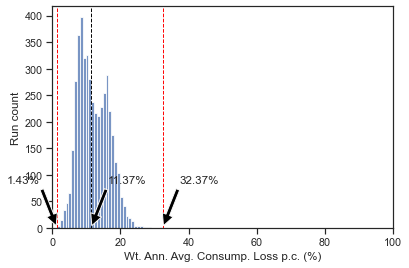

In [7]:
annotated_hist(outcomes, savefig)

### Multiple scenarios & multiple districts

In [8]:
# Let's aggregate across scenarios and take the mean
outcomes.iloc[:, 2:-1].groupby('district').mean(numeric_only=True).round(2).style.format("{:,.2f}")

,total_population,total_asset_loss,total_consumption_loss,tot_exposed_asset,median_productivity,tot_asset_surv,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,district_pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,mean_recovery_rate,n_new_poor_increase_pp
district,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"8,666.91","1,279,322.95","1,095,654.90","47,442,177.05",0.63,"334,331,195.84",0.03,636.99,"1,591.22",914.27,"1,282,936.18","3,292.00",229.58,42.89,32.85,33.18,178.90,10.43,1.18,0.57,0.49
Castries,"70,959.09","31,031,634.81","19,953,572.67","1,587,405,663.34",0.11,"3,435,721,049.12",0.02,"3,120.21","6,213.45","2,976.86","31,062,668.40","15,948.00",712.77,202.01,34.78,34.73,675.69,10.82,1.56,0.15,0.28
Choiseul,"5,475.87","1,111,548.14","735,202.69","54,354,802.37",0.23,"377,890,219.98",0.02,260.05,"1,932.86",926.75,"1,111,847.84",923.00,44.94,27.91,26.55,26.80,291.64,14.98,1.52,0.17,0.51
Dennery,"11,590.78","2,665,548.25","1,549,098.45","125,372,604.01",2.46,"417,528,403.13",0.02,572.13,"3,383.57","1,934.66","2,667,414.34","5,216.00",255.67,11.66,23.52,23.78,283.76,8.08,1.77,2.22,0.10
Gros Islet,"27,467.06","10,912,143.48","8,125,631.76","532,061,766.39",0.70,"3,294,339,146.51",0.02,"1,466.85","2,841.95","1,040.60","10,932,607.53","3,245.00",132.89,109.40,15.39,15.52,583.71,17.87,1.36,0.70,0.40
Laborie,"6,828.32","2,033,995.90","1,354,803.84","99,235,698.32",0.12,"215,695,044.06",0.02,309.15,"5,123.26","2,964.26","2,035,118.22","1,599.00",68.93,10.82,23.26,23.42,463.37,8.84,1.51,0.16,0.16
Micoud,"17,435.51","4,761,748.95","3,388,671.47","231,995,156.10",0.26,"554,020,360.02",0.02,813.75,"6,056.25","2,698.00","4,766,541.74","5,433.00",268.07,40.12,38.18,38.22,439.64,7.58,1.42,0.21,0.23
Soufriere,"8,985.05","1,678,483.90","1,268,385.95","82,756,712.06",0.18,"535,928,432.44",0.02,431.23,"2,953.40",994.91,"1,679,254.31","2,295.00",103.00,36.58,31.47,31.56,308.39,13.65,1.33,0.23,0.41
Vieuxfort,"15,229.37","4,254,100.06","3,286,897.56","216,534,648.76",0.75,"1,266,550,258.12",0.02,"1,002.28","2,121.05","1,101.52","4,264,030.49","5,272.00",303.51,140.43,23.35,23.75,342.60,15.96,1.33,0.72,0.92


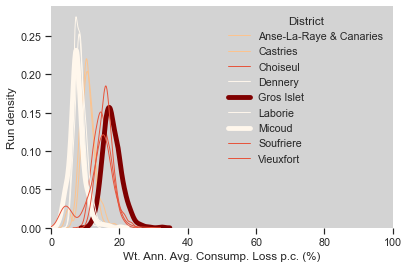

In [22]:
coloured_density_plots(outcomes, savefig, scheme='fisher_jenks', k=4)

In [19]:
tab = outcomes.iloc[:, 2:-1].groupby('district').describe().round(2)
column = 'annual_average_consumption_loss_pct'
tab = tab.sort_values(by=(column, 'mean'), ascending=False)
tab[[column]].iloc[:,1:].style.format("{:,.2f}")

In [ ]:
tab = pd.DataFrame(d).describe().T.sort_values('mean', ascending=False).round(2)
tab.drop(['count'], axis=1, inplace=True)
if savetab:
    tab.to_latex(buf='../reports/tables/annual_average_consumption_loss_by_district.tex', 
                 float_format="%.2f", 
                 bold_rows=True, 
                 label='tab:analysis_income_loss=False', 
                 caption='Analysis of the results of the experiments with income loss set to False.', 
                 index=True)

## Number of new poor & Weeks in poverty

In [50]:
# Get the number of new poor in each district
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
d = {}
for district in districts:
    df = outcomes[outcomes['district'] == district]
    d[district] = df['n_new_poor'].values.tolist()

In [51]:
# Make a coloured table
tab = pd.DataFrame(d).describe().T.sort_values('mean', ascending=False).round(2).drop('count', axis=1)
tab.style.background_gradient(cmap='Blues', subset=['mean'])\
         .background_gradient(cmap='Reds', subset=['std'])\
         .background_gradient(cmap='Greens', subset=['min'])\
         .background_gradient(cmap='Greens', subset=['25%'])\
         .background_gradient(cmap='Greens', subset=['50%'])\
         .background_gradient(cmap='Greens', subset=['75%'])\
         .background_gradient(cmap='Greens', subset=['max'])\
         .format(decimal='.', thousands=',', precision=2)

,mean,std,min,25%,50%,75%,max
Castries,202.01,219.65,0.00,0.00,149.50,333.75,"1,613.00"
Vieuxfort,140.43,150.10,0.00,22.00,92.00,221.25,740.00
Gros Islet,109.40,125.92,0.00,0.00,69.00,174.00,710.00
Anse-La-Raye & Canaries,42.89,37.07,0.00,14.00,35.00,61.25,224.00
Micoud,40.12,59.54,0.00,0.00,14.00,51.00,439.00
Soufriere,36.58,36.86,0.00,5.00,30.00,55.25,245.00
Choiseul,27.91,23.70,0.00,10.75,23.00,40.00,118.00
Dennery,11.66,23.77,0.00,0.00,0.00,4.25,162.00
Laborie,10.82,15.95,0.00,0.00,0.00,20.00,88.00


In [12]:
average_years_in_poverty = get_weeks_in_poverty_tab(outcomes, max_years=10)
average_years_in_poverty.astype(int).style.background_gradient(cmap='Blues', axis=0)\
                                          .set_caption('Average Years in Poverty By District')

100%|██████████| 500/500 [00:04<00:00, 102.04it/s]


,0,1,2,3,4,5,6,7,8,9,>10
Anse-La-Raye & Canaries,0,0,6,19,8,5,1,0,0,0,0
Castries,0,7,18,26,34,31,35,14,8,12,13
Choiseul,0,0,0,3,3,3,3,2,3,2,4
Dennery,0,3,6,1,0,0,0,0,0,0,0
Gros Islet,0,0,20,34,27,14,4,2,2,2,0
Laborie,0,0,0,0,2,2,2,1,0,0,0
Micoud,0,0,0,8,14,9,2,1,0,0,0
Soufriere,0,0,0,4,10,5,3,4,4,1,1
Vieuxfort,0,4,41,50,41,1,1,0,0,0,0


## Raincloud plots

Raincloud plot is a combination of a boxplot, a kernel density plot, and a dot plot. It is a great way to visualize the distribution of the data. Especially, when the distribution is skewed and you have a lot of data points.

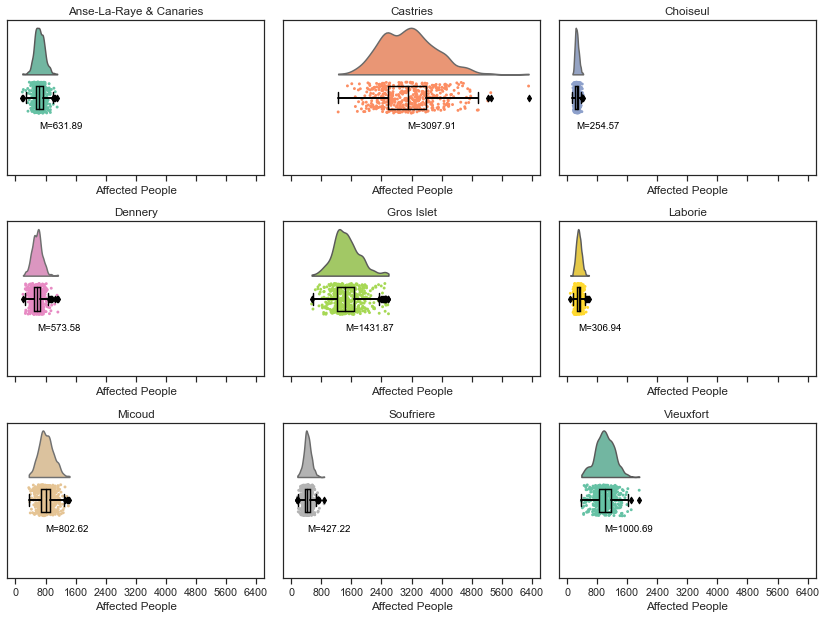

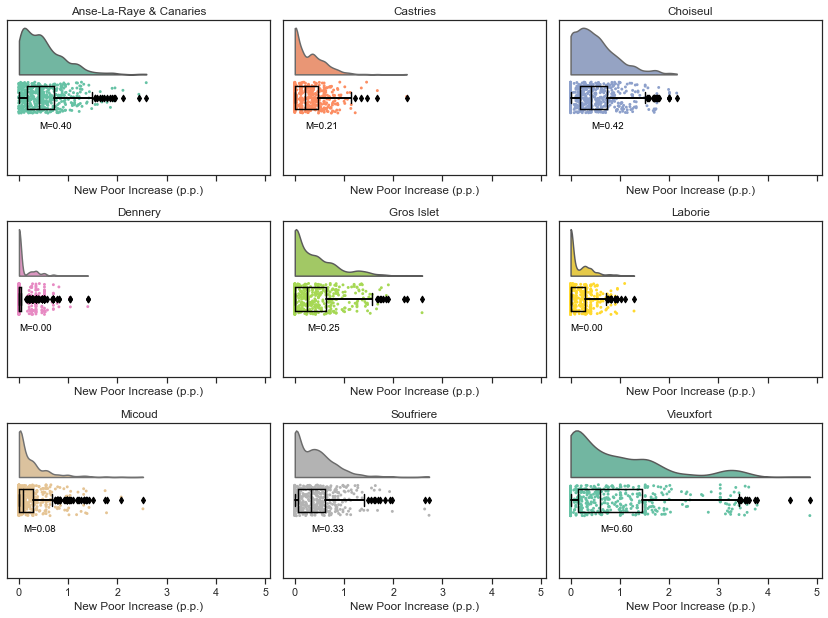

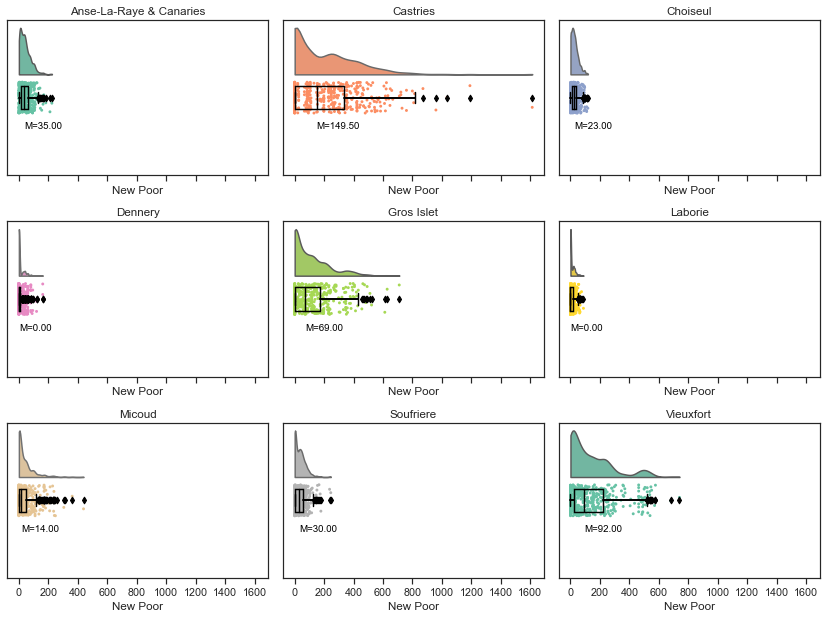

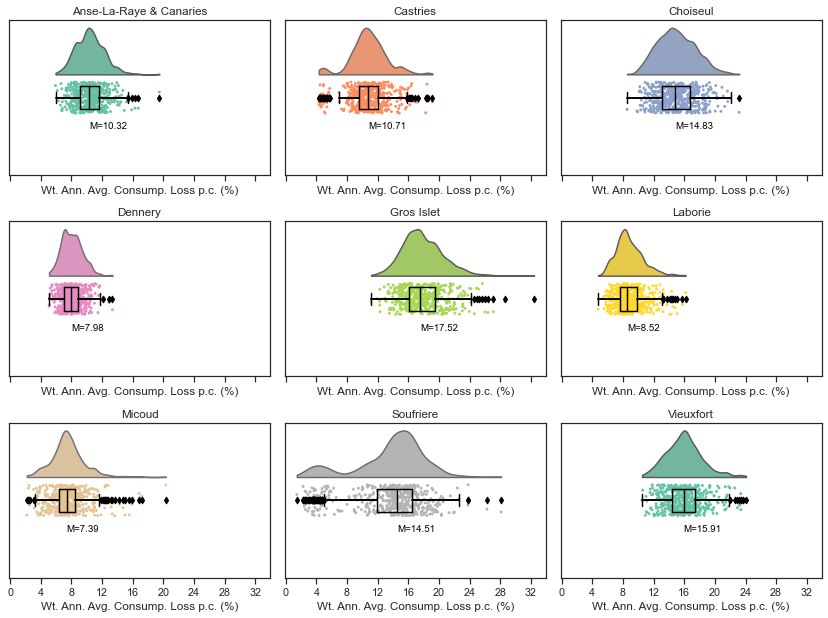

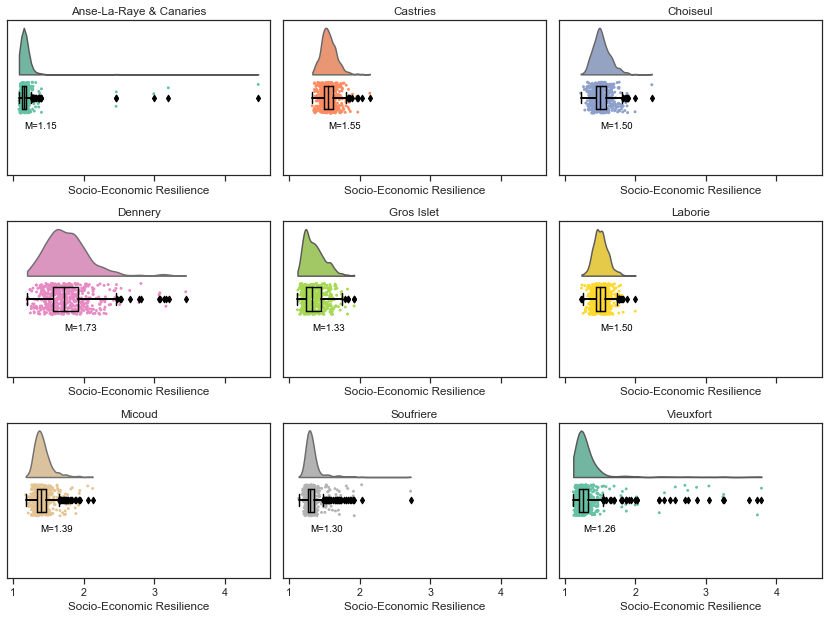

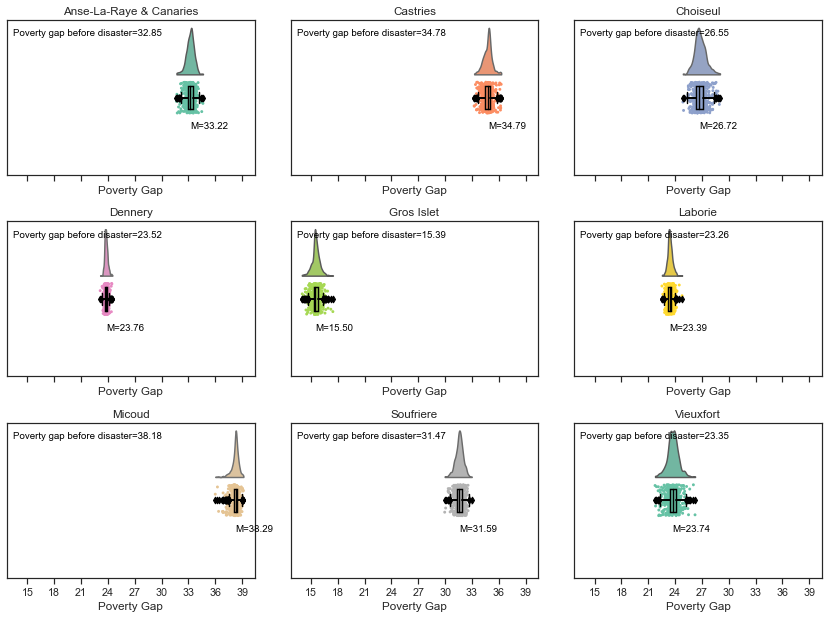

In [13]:
raincloud_plot(outcomes, savefig=savefig)

## Choropleth maps

Another way to visualize the outcomes is to use choropleth maps. These maps are useful when you have data that is aggregated by a geographic area. For example, if we have data on how many people became poor after a disaster in the districts of Saint Lucia, we could use a choropleth map to show these numbers.  

What is important to remember is that **these maps do not show the variance** within each district. Instead, they show the mean or median value for each district.

In [15]:
# Get the country shapefile and aggregated outcomes
country = gpd.read_file('../data/raw/shapefiles/Saint Lucia/gadm36_LCA_shp/gadm36_LCA_0.shp')
aggregation = 'median'
outcomes['district'].replace({'Anse-La-Raye \& Canaries' : 'Anse-La-Raye & Canaries'}, inplace=True)
aggregated_outcomes = get_spatial_outcomes(outcomes, aggregation=aggregation)

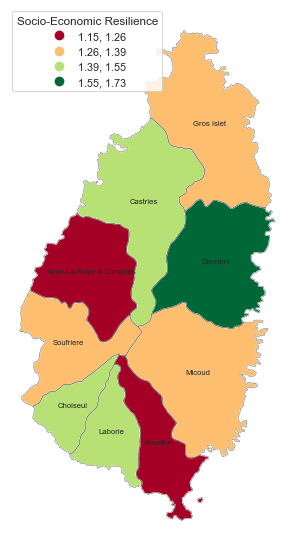

In [19]:
k = 4
scheme = 'fisher_jenks'
ax = aggregated_outcomes.plot(column='r', scheme=scheme, k=k, cmap='RdYlGn', legend=True, figsize=(10,10), legend_kwds={"title":"Socio-Economic Resilience", "loc" : "upper left"})
aggregated_outcomes.plot(ax=ax, color='none', edgecolor='black', linewidth=0.25)
ax.axis('off')
for idx, row in aggregated_outcomes.iterrows():
    ax.annotate(text=row['NAME_1'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
if savefig:
    plt.savefig(f'../reports/figures/analysis/soc_econ_res_map.png', dpi=300, bbox_inches='tight')

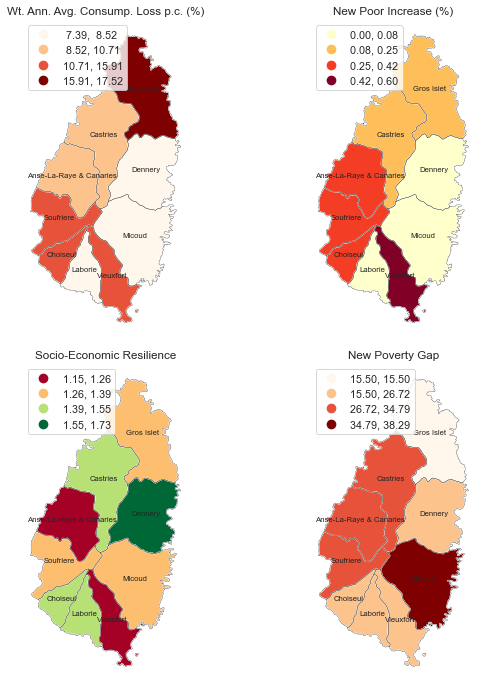

In [21]:
# Plot the outcomes in a 2 by 2 grid
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
outcomes_to_plot = ['annual_average_consumption_loss_pct', 'n_new_poor_increase_pp', 'r', 'new_poverty_gap']
titles = ['Wt. Ann. Avg. Consump. Loss p.c. (%)', 
          'New Poor Increase (%)', 
          'Socio-Economic Resilience', 'New Poverty Gap']
cmaps = ['OrRd', 'YlOrRd', 'RdYlGn', 'OrRd']
k = 4
for i, outcome in enumerate(outcomes_to_plot): 
    aggregated_outcomes.plot(column=outcome, scheme='fisher_jenks', cmap=cmaps[i], k=k, ax=ax[i//2, i%2], legend=True, legend_kwds={"loc" : "upper left"})
    aggregated_outcomes.plot(ax=ax[i//2, i%2], color='none', edgecolor='black', linewidth=0.25)
    ax[i//2, i%2].set_title(titles[i])
    ax[i//2, i%2].axis('off')
    for idx, row in aggregated_outcomes.iterrows():
        ax[i//2, i%2].annotate(text=row['NAME_1'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
# fig.suptitle(f'{aggregation.capitalize()} of 3,000 replications', fontsize=16)
fig.tight_layout()
if savefig:
    plt.savefig(f'../reports/figures/analysis/{aggregation}_outcomes_spatially.png', dpi=300, bbox_inches='tight')

A bivariate or bi-variate choropleth helps to visualise relations between two variables spatially. 

In [23]:
# Load asset damage data
asset_damage = pd.read_excel('../data/processed/asset_damage/Saint Lucia.xlsx')
asset_damage['district'].replace({'AnseLaRayeCanaries' : 'Anse-La-Raye & Canaries'}, inplace=True)
gdf = pd.merge(aggregated_outcomes, asset_damage, left_on='NAME_1', right_on='district', how='left')

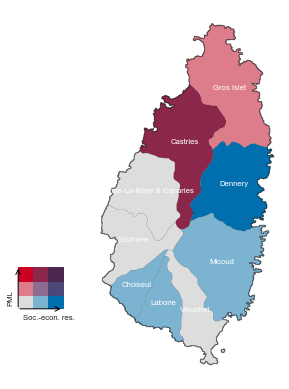

In [24]:
x_name = 'r'
y_name = 'pml'
x_label = 'Soc.-econ. res.'
y_label = 'PML'

tab = bivariate_choropleth(gdf.copy(), x_name, y_name, x_label, y_label, scheme='fisher_jenks', figsize=(7,6), return_table=True)
if savefig:
    plt.savefig('../reports/figures/analysis/bivariate_choropleth.png', dpi=300, bbox_inches='tight')

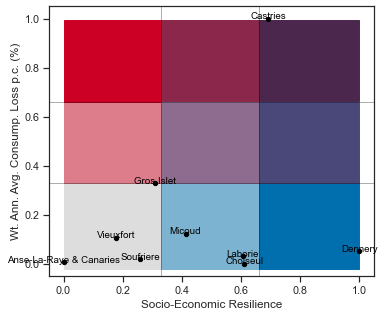

In [26]:
nine_quadrants_plot(gdf.copy(), x_name, y_name)
plt.xlabel('Socio-Economic Resilience')
plt.ylabel('Wt. Ann. Avg. Consump. Loss p.c. (%)')
if savefig:
    plt.savefig('../reports/figures/analysis/9_quadrants.png', dpi=300, bbox_inches='tight')